In [13]:
import pandas as pd
from pathlib import Path
seed = 3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
# Specify the directory path
directory_path = Path('../ephemeral/sign/mtsd_v2_fully_annotated/annotations')

# Get the list of directories in the specified directory

 

In [53]:
import requests
from PIL import Image
import torch
import numpy as np
import cv2
from geopy.geocoders import Nominatim
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# objectProcessor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
# objectModel = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

objectProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
objectModel = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

2024-04-19 02:52:12.803103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 02:52:12.803211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 02:52:12.803241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 02:52:17.164010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
directories = [[entry.name] for entry in directory_path.iterdir() if not entry.is_dir()]

# directories

[['QfGHeb7nzGHkzjDuMvWNmg.json'],
 ['CMS6rqwiw5HkpPWI4kgOAg.json'],
 ['bd0QuMy_j2Lj3vfG4Crrdg.json'],
 ['-rgmq1yn5WtkY_9TbHaV9w.json'],
 ['vKbq77Qs1UUiXiWH3FhqUw.json'],
 ['_k0ltGi_BSbQxo2oqxFpyw.json'],
 ['xXmOrAq7eU21uOd-w0Vw2Q.json'],
 ['X0m7DUCjxDtp6M_F0Ja1DA.json'],
 ['mVZUTcFSuE66squChLRb-g.json'],
 ['T6rO51tEv4TxF05hAeF6mw.json'],
 ['JzOhbBIIRg_iCuMaW_JnxA.json'],
 ['Qcy5Gje4hvrmWlxs-eDCRQ.json'],
 ['B_2a2ne1J5AI8PlcQHrumA.json'],
 ['MMFXHo4ThGbzu2vaeRiQBw.json'],
 ['yC9BzKM-xzyJU8foFPIH8A.json'],
 ['xxRmmUBKZ2F1JMDtKYrVVQ.json'],
 ['xvUPvOD5cb8WS3oMev4aug.json'],
 ['YXIB8UEH4ZhiHucc254lfA.json'],
 ['tIUU-wtkNLcWnRCZt1BZqQ.json'],
 ['L88wQK1m-gBomF_35K77BA.json'],
 ['97HoX-fXMeCfp3cti3obmg.json'],
 ['G3vL-9DoiiwQB29ZjQfd_A.json'],
 ['BkzU_IgX9E6PgdAGT8MFDQ.json'],
 ['yNsVHCzkyMYnGrqEe6t3XQ.json'],
 ['MsoFm8iSRoDQIohrpoQobw.json'],
 ['gKcxrZ-hcpjwhD9hduPBMQ.json'],
 ['z7NY72mBnpNr1OWaDDrX0A.json'],
 ['nVuRFOJG32vboVbLCPRhTA.json'],
 ['H8x5IzT0sp_ZYNdEh6GaXw.json'],
 ['3reTKZqRKLS

In [135]:
# !ls ../ephemeral/sign/mtsd_v2_fully_annotated/annotations  
# !head ../ephemeral/sign/mtsd_v2_fully_annotated/splits/train.txt
!head ../ephemeral/sign/mtsd_v2_fully_annotated/splits/train.txt 	  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


aVuSPwmImhhe01o_hJm7IA
cydOiChUMzcddBqofGmlYQ
iMeyPoRIiG_jtafHEXkNuA
yBt7KOsmqzNZr9dK9FOdAA
lWhwLkHcnSv7KS9IvK_4pw
ZmBgrd5XWn2lQ8MYWLIYjg
_VN5K3fdBURuhWp4FcwE8w
BuVTuDwmc6CKb82A6lO6xw
cKteiwqaegnI6EEaIiQZ5A
a7kJZef6vIolqAzS-qInJg


In [16]:
directories = pd.DataFrame(directories, columns=['label'])


In [17]:
directories.head()

,label
0,QfGHeb7nzGHkzjDuMvWNmg.json
1,CMS6rqwiw5HkpPWI4kgOAg.json
2,bd0QuMy_j2Lj3vfG4Crrdg.json
3,-rgmq1yn5WtkY_9TbHaV9w.json
4,vKbq77Qs1UUiXiWH3FhqUw.json


In [18]:
import json

In [71]:
SMOOTH = 1e-6

def iou_numpy(outputs: np.array, labels: np.array):
    # outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded.mean()  # Or thresholded.mean()

In [52]:
import numpy as np


0.4


In [105]:
import json
import numpy as np

def generate_mask_from_json(json_data):
    """
    Generates a binary mask from a JSON file following the specified schema.

    Args:
        json_data (dict): The loaded JSON data.
        image_width (int): Width of the corresponding image.
        image_height (int): Height of the corresponding image.

    Returns:
        np.array: A binary mask with the same dimensions as the image.
    """

    mask = np.zeros((json_data["height"], json_data["width"]), dtype=np.uint8)  # Initialize empty mask

    for obj in json_data['objects']:
        if obj['label'] == 'other-sign' or True:  # Filter for the desired object label
            xmin, ymin, xmax, ymax = obj['bbox'].values()

            # Convert float coordinates to integer pixel coordinates 
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

            # Draw the bounding box on the mask
            mask[ymin:ymax, xmin:xmax] = 1 

    return mask[:, :, None]

In [91]:


key = "G0L0qVL9d1KDLKPsvMW3YA"



json_file = f"../ephemeral/sign/mtsd_v2_fully_annotated/annotations/{key}.json"
image_file = f"../ephemeral/sign/images/{key}.jpg"
img = np.array(Image.open(f"../ephemeral/sign/images/{key}.jpg"))
with open(json_file) as f:
    data = json.load(f)
    # print( json.dumps(data, indent=2))

In [122]:
# generate_mask_from_json(data)
json_file

'../ephemeral/sign/mtsd_v2_fully_annotated/annotations/G0L0qVL9d1KDLKPsvMW3YA.json'

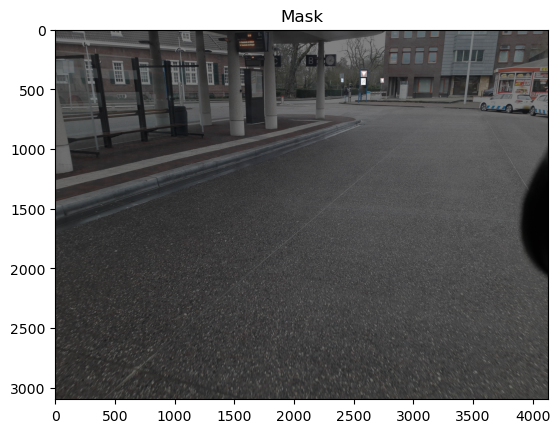

In [106]:
from PIL import Image

plt.imshow(img)
plt.imshow(generate_mask_from_json(data), cmap='gray', alpha=0.5)  # Use a grayscale colormap
plt.title('Mask')
plt.show()

In [34]:
def process_image(label_file):
    with open(json_file) as f:
        data = json.load(f)
    image_path = '../ephemeral/sign/images/' + label_file[:-5] + '.jpg'
    image = plt.imread(image_path)
    return image

In [93]:
def run_object_detection(image, text):
    # image = crop_image(image, 0, 0, 1600, 1205)
    # Preprocess the image
    inputs = objectProcessor(text=[text],images=image, return_tensors="pt")

    # Perform inference
    outputs =  objectModel(**inputs)
    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.size[::-1]])
    # print(target_sizes)
    # Convert outputs (bounding boxes and class logits) to COCO API
    results = objectProcessor.post_process_object_detection(outputs=outputs, threshold=0.1,  target_sizes=target_sizes)

    i = 0  # Retrieve predictions for the first image for the corresponding text queries
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    return boxes


boxes = run_object_detection(Image.open(image_file), "a traffic sign")

In [87]:
i = 0

In [114]:
# keys = ["00aqYRN4650NUaZxWCMFOw",  
# "G0L0qVL9d1KDLKPsvMW3YA",
# "00BAyjD4Q0S5_zE4bM6FvA",  
# "-g0lUdhE9D4_hL9QIjF0iQ",
# "00-BnNquK24qWw8IAFyXJQ",  
# "G0oe_93d0a4dTOXHAW1NDg",
# "00Bw2Cj3hJW3NEgrnfB3Lg",  
# "g0Pt4o9ixHeRLDiVYHz9kg",
# "00bW367UK3y48mwThU88Qg",  
# "G0pwRZVxlOEIebQDYm8ZwA",
# "00bXGGGwg06dZnzJLnUnzg",  
# "g0RiGURzAhfwR0AAPNodkQ",
# "00CPBbi50rnROtcdEFVpwA",  
# "g0RSOKiK--xCSh5JGIu8mQ",
# "00CY0LHfD--IzKjfm_NfUQ",  
# "g0u_RMBUUgbZz_4dl9QOrw",
# "00E3Bng_uIEUTIxtqSHuqg",  
# "g0Vdga0vJenU3t2swg5Xvg",
# "00esmAinHAQ3bngGcaNGng",  
# "g0WJwZBXiLSCP1gdrWB5bQ",
# "00F3yHgUv3wWS1aQoRU9Ig",  
# "G0XBPJQ9VuqmGdeLeyXvxQ",
# "00GjpZD_nrnmm7SkNDoTeQ",  
# "g0yfinRisUlCg52zYeYXXw",
# "00JgOXF8R8Ucd07rR3iTlA",  
# "G0z7WXq4UZokYm8Nn_VGfg",
# "00KqHnWpdHWD46dC3Y-RDQ",  
# "G0z9tnp08LC45Md6dHwTDg",
# "00MCICN-74wDrc0_WWKTIg",  
# "G17mMqznlttxh7VGuPb2Jg"]

# key = keys[i]
# print(key)
# print(i)
image_file = f"../ephemeral/sign/images/{key}.jpg"
boxes = run_object_detection(Image.open(image_file), "a traffic sign")

# print(boxes)
# i+=1

In [119]:
image_file

'../ephemeral/sign/images/G0L0qVL9d1KDLKPsvMW3YA.jpg'

In [73]:
iou_numpy(generate_mask_from_json(data), generate_mask_from_json(data))

1.0

In [113]:
def generate_mask_from_boxes(boxes, height, width):
    """
    Generates a binary mask from a list of bounding boxes

    Args:
        boxes tensor([], size=(0, 4), grad_fn=<IndexBackward0>): The bounding boxes of the detected objects.
    Returns:
        np.array: A binary mask with the same dimensions as the image.
    """

    mask = np.zeros((height,width), dtype=np.uint8)  # Initialize empty mask

    for obj in boxes:
        xmin, ymin, xmax, ymax = obj

        # Convert float coordinates to integer pixel coordinates 
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

        # Draw the bounding box on the mask
        mask[ymin:ymax, xmin:xmax] = 1 

    return mask[:, :, None]

# generate_mask_from_boxes(boxes, data["height"], data["width"])

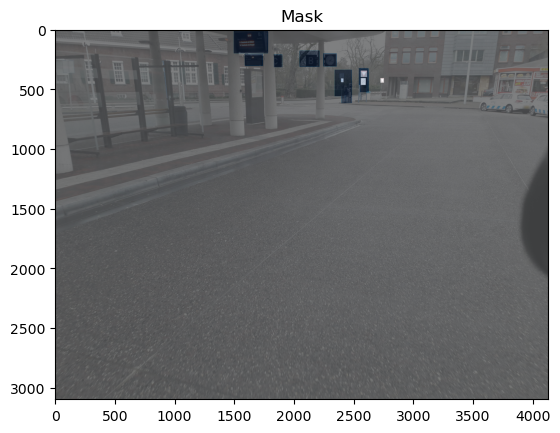

In [115]:
from PIL import Image

plt.imshow(img)
plt.imshow(generate_mask_from_boxes(boxes, data["height"], data["width"]), cmap='Blues', alpha=0.5)  # Use a grayscale colormap
plt.imshow(generate_mask_from_json(data), cmap='grey', alpha=0.5)  # Use a grayscale colormap
plt.title('Mask')
plt.show()

In [107]:
mask1 = generate_mask_from_json(data)

In [108]:
print(mask1.shape)


(3096, 4128, 1)


In [116]:
mask2 = generate_mask_from_boxes(boxes, data["height"], data["width"])
print(mask2.shape)

(3096, 4128, 1)


In [129]:
def process_image(key):
    json_file = f"../ephemeral/sign/mtsd_v2_fully_annotated/annotations/{key}.json"
    with open(json_file) as f:
        data = json.load(f)
    image_file = '../ephemeral/sign/images/' + key + '.jpg'
    # image_file = f"../ephemeral/sign/images/{key}.jpg"
    boxes = run_object_detection(Image.open(image_file), "a traffic sign")
    return iou_numpy(generate_mask_from_json(data), generate_mask_from_boxes(boxes, data["height"], data["width"]))


def debug_image(label_file):
    json_file = f"../ephemeral/sign/mtsd_v2_fully_annotated/annotations/{key}.json"
    with open(json_file) as f:
        data = json.load(f)
    image_file = '../ephemeral/sign/images/' + key + '.jpg'
    # image_file = f"../ephemeral/sign/images/{key}.jpg"
    boxes = run_object_detection(Image.open(image_file), "a traffic sign")
    plt.imshow(Image.open(image_file))
    plt.imshow(generate_mask_from_boxes(boxes, data["height"], data["width"]), cmap='Blues', alpha=0.5)  # Use a grayscale colormap
    plt.imshow(generate_mask_from_json(data), cmap='grey', alpha=0.5)  # Use a grayscale colormap
    plt.title('Mask')
    plt.show()

In [130]:
process_image('G0L0qVL9d1KDLKPsvMW3YA')

0.8052325581395349

In [ ]:

directories = pd.DataFrame(directories, columns=['place'])
place = directories.sample(1,  random_state=seed).reset_index()['place'].loc[0]
sample  = 300


df  = pd.read_csv(f"mappilary/train_val/{place}/database/postprocessed.csv")
df_raw = pd.read_csv(f"mappilary/train_val/{place}/database/raw.csv")
df = pd.merge(df, df_raw[['key', 'lat', 'lon']], on='key', how='left')

from PIL import Image
from IPython.display import display
# img = Image.open(f"mappilary/train_val/{place}/database/images/{df['key'][sample]}.jpg")
img = Image.open("mappilary/train_val/london/database/images/_TPTTeDgH5f_l5bz-ZK-wA.jpg")
           
display(img)
print(place)

import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def run_text_extraction_multiline(x,y,w,h):
    textSeg = crop_image(img,x,y,w,h)
    print(reader.readtext(textSeg))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(textSeg)